# Data Cleaning
- Load data that has been processed in OpenRefine and make some general tweaks
- Split est_price into quantity and price columns
    - Cleanup quantity units and convert all values to single unit
    - Cleanup and standardize currency symbols
- Load historical exchange rate data, and convert all data to historical USD using the exchange rate from the month of the 
review date
- Load consumer price index data from BLS. Use this to convert all historical USD prices to January 2024 USD prices
- Cleanup geographic data
    - Create a column for all counties
    - Create a column for US State
    - Check country column is only countries

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', None)
mpl.rcParams['figure.dpi']= 300

In [2]:
data_dir = Path('../../data')
file_path = data_dir / 'interim' / '05052024_roast_review_openrefine.csv'
df_raw = pd.read_csv(file_path)

display(df_raw.info())
display(df_raw.sample(5))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6539 entries, 0 to 6538
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rating                            6539 non-null   int64  
 1   roaster                           6539 non-null   object 
 2   title                             6539 non-null   object 
 3   blind_assessment                  6539 non-null   object 
 4   bottom_line                       3260 non-null   object 
 5   roaster_location                  6538 non-null   object 
 6   coordinate location               6538 non-null   object 
 7   og_roaster_location               6537 non-null   object 
 8   roaster_location_identifier       6538 non-null   object 
 9   territorial_entity_1              6531 non-null   object 
 10  territorial_entity_1_identifiers  6531 non-null   object 
 11  territorial_entity_2              5889 non-null   object 
 12  territ

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,with_milk,url,acidity/structure,acidity,notes
987,95,Hula Daddy Kona Coffee,Kona Natural Espresso,"Evaluated as espresso. Richly chocolaty, sweet...",A Kona on steroids: Hula Daddy is just beginni...,Holualoa,"19.616353,-155.968278","Holualoa, Hawaii",Q2101741,Hawaii County,Q487334,Hawaii,Q782,USA,"Kona growing region, Big Island, Hawaii, USA",United States of America,Medium-Light,57/77,$62.95/8 ounces,June 2022,9.0,9.0,9.0,9.0,9.0,https://www.coffeereview.com/review/kona-natur...,NaN,NaN,"Produced by Karen and Lee Patterson, of Hula D..."
3932,91,Kakalove Cafe,Sumatra Lake Tawar Screen 19 Plus TP,"Sweet-toned, pungent, heavy. Prominent notes o...",NaN,Chiayi City,"23.48,120.44972222222","Chia-Yi, Taiwan",Q249995,Taiwan Province,Q32081,Taiwan,Q865,Taiwan,"Aceh Growing Region, Sumatra, Indonesia",Indonesia,Medium-Dark,45/55,NT $600/16 ounces,January 2014,8.0,8.0,9.0,8.0,NaN,https://www.coffeereview.com/review/sumatra-la...,NaN,8,Lake Tawar is situated in a crater valley at t...
6359,86,Natchitoches Coffee Company,Nakatosh Special Dark Roast,The sweet musty tones that run from aroma into...,NaN,Natchitoches,"31.7431,-93.095","Natchitoches, Louisiana",Q2278195,Natchitoches Parish,Q507047,Louisiana,Q1588,USA,NaN,Namibia,Dark,35/46,NaN,December 2003,7.0,7.0,7.0,NaN,NaN,https://www.coffeereview.com/review/nakatosh-s...,NaN,7,Nakatosh Special Dark Roast is a traditional l...
1992,94,Paradise Roasters,Colombia Finca Lord Baltimore Papayo,"Floral, citrusy, delicate yet deeply sweet. Ho...","A bright, richly aromatic Colombia cup from a ...",Minneapolis,"44.981944444444444,-93.26916666666666","Minneapolis, Minnesota",Q36091,Hennepin County,Q486229,Minnesota,Q1527,USA,"Pitalito, Huila Department, Colombia",Colombia,Light,62/80,$24.95/12 ounces,May 2020,9.0,9.0,9.0,8.0,NaN,https://www.coffeereview.com/review/colombia-f...,9.0,NaN,Produced by Deiro Garcia in Colombia at Finca ...
1505,93,De Clieu Coffee,Ethiopia Guji Natural Anaerobic Wush Wush G1,"Earth-toned, richly sweet-savory. Moist cedar,...","A richly low-toned, crisply chocolaty, sweetly...",Taipei,"25.0375,121.5625","Taipei, Taiwan",Q1867,Taiwan,Q865,NaN,NaN,Taiwan,"Sidamo growing region, Ethiopia",Ethiopia,Medium-Light,56/72,NT $650/8 ounces,May 2021,9.0,9.0,9.0,8.0,NaN,https://www.coffeereview.com/review/ethiopia-g...,8.0,NaN,Produced by smallholding farmers entirely of t...


In [3]:
def tweak_df(df: pd.DataFrame) -> pd.DataFrame:
    return(
        df
        .assign(review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                # Combing acidity and acidity/structure into one column, they are the same 
                # field but names used in reviews changed at one point
                acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                # Split the agtron column into one for external bean agtron data and ground 
                # bean agtron data
                agtron_external=lambda x: pd.to_numeric(x['agtron']
                                    .str.split('/', expand=True)[0]
                                    .str.strip(), errors='coerce'),
                agtron_ground = lambda x: pd.to_numeric(x['agtron']
                                        .str.split('/', expand=True)[1]
                                        .str.strip(), errors='coerce'
                                        )
        )
        .dropna(subset=['agtron_external', 'agtron_ground', 'acidity',
                        'review_date', 'est_price', 'coffee_origin',
                        'aroma', 'roast_level', 'aftertaste',]
        )
        .drop(columns=['with_milk', 'acidity/structure',])
        .astype({'acidity': 'float'})
        .replace('', np.nan)
        # Agtron values must be equalt to or below 100, some entries on website have typos 
        .loc[lambda df_: (df_['agtron_external'] <= 100) & (df_['agtron_ground'] <= 100), :]
        # Run str.strip on every string column
        .applymap(lambda x: x.strip() if isinstance(x, str) else x)

    )


df = df_raw.pipe(tweak_df)

# Save the review dates to a separate file
#df.review_date.drop_duplicates().to_csv(data_dir / 'processed' / 'review_dates.csv', index=False)

display(df[df['agtron_external'] > 100])
display(df.info())
display(df.sample(3))


,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,url,acidity,notes,agtron_external,agtron_ground


<class 'pandas.core.frame.DataFrame'>
Index: 4375 entries, 1 to 5163
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4375 non-null   int64         
 1   roaster                           4375 non-null   object        
 2   title                             4375 non-null   object        
 3   blind_assessment                  4375 non-null   object        
 4   bottom_line                       2860 non-null   object        
 5   roaster_location                  4375 non-null   object        
 6   coordinate location               4375 non-null   object        
 7   og_roaster_location               4375 non-null   object        
 8   roaster_location_identifier       4375 non-null   object        
 9   territorial_entity_1              4373 non-null   object        
 10  territorial_entity_1_identifiers  4373 non-null   obj

None

,rating,roaster,title,blind_assessment,bottom_line,roaster_location,coordinate location,og_roaster_location,roaster_location_identifier,territorial_entity_1,territorial_entity_1_identifiers,territorial_entity_2,territorial_entity_2_identifiers,roaster_country,coffee_origin,coffee_origin_country,roast_level,agtron,est_price,review_date,aroma,body,flavor,aftertaste,url,acidity,notes,agtron_external,agtron_ground
33,94,Buon Caffe,Kenya Nyeri Kianjogu AA TOP Washed,"Bright, juicy, richly sweet-savory. Black curr...",A nuanced Kenya with characteristic currant no...,Taipei,"25.0375,121.5625","Taipei, Taiwan",Q1867,Taiwan,Q865,NaN,NaN,Taiwan,"Nyeri growing region, Kenya",Kenya,Light,62/82,NT $400/8 ounces,2024-04-01,9.0,9.0,9.0,8.0,https://www.coffeereview.com/review/kenya-nyer...,9.0,Buon Caffe is a specialty coffee roaster and c...,62.0,82.0
5033,93,Coava Coffee Roasters,Kenya Kieni,"Soft, smooth aroma combining night flowers, or...",NaN,Portland,"45.516666666667,-122.66666666667","Portland, Oregon",Q6106,Multnomah County,Q450374,Oregon,Q824,USA,"Nyeri growing region, Kenya",Kenya,Medium,47/60,$11.00/8.8 oz.,2010-08-01,8.0,8.0,9.0,9.0,https://www.coffeereview.com/review/kenya-kieni/,9.0,Despite grower discontent and sporadic social ...,47.0,60.0
3717,93,Paradise Roasters,Sumatra Tano Batak,"Spicy, chocolaty. Sandalwood, dark chocolate, ...",NaN,Ramsey,"45.232055555555554,-93.4605","Ramsey, Minnesota",Q1992875,Anoka County,Q110495,Minnesota,Q1527,USA,"Lintong Growing Region, North Sumatra Province...",Indonesia,Medium,50/57,$13.95/12 ounces,2014-09-01,9.0,8.0,9.0,9.0,https://www.coffeereview.com/review/sumatra-ta...,8.0,This coffee was grown by indigenous Batak peop...,50.0,57.0


## Quantity and Price Data Cleaning
Here we will split est_price into a column for quantity, quantity unit, price, and currency. Currency symbols will be standardized and all prices will be converted to USD. Quanity units will be cleaned then used to create a column for quantity in lbs. 

In [5]:

def price_quantity_split(df: pd.DataFrame) -> pd.DataFrame:
    price_quantity = (
        df
        .replace(',', '', regex=True)
        # Split est_price into columns for price and quantity
        .est_price.str.split("/", n=1, expand=True)
        .rename(columns={0: 'price', 1: 'quantity'})
        .assign(quantity = lambda df_: (df_['quantity']
                                        # Remove anything in parentheses, including the parentheses
                                        .str.replace(r"\(.*?\)", "", regex=True)
                                        # Remove anything after a semicolon
                                        .str.replace(r";.*", "", regex=True)
                                        # Standardize units
                                        .str.replace(r".g$", " grams", regex=True)
                                        .str.replace(r"\sg$", "grams", regex=True)
                                        .str.replace(r"pound$", "1 pounds", regex=True)
                                        .str.replace(r"oz|onces|ounce$|ounces\*", "ounces", regex=True)
                                        # Removie "online" from any quantity
                                        .str.replace("online", "")
                                        .str.strip()
                                        )
            )
        .dropna()
        # Remove rows where coffee is sold in a can, box, pouch, packet, or tin
        .loc[lambda df_: ~df_['quantity'].str.contains('can|box|pouch|packet|tin'), :]
        # Split quantity into value and unit, and split price into value and currency
        .assign(quantity_value = lambda df_: (df_['quantity']
                                              .str.extract(r'(\d+)')
                                              .astype(float)
                                              ),
                quantity_unit = lambda df_: (df_['quantity']
                                             .str.replace(r"(\d+)", "", regex=True)
                                             .replace("\.", "", regex=True)
                                             .str.strip()
                                             .mask(lambda s: s == 'g', 'grams')
                                             .str.strip()
                                             ),
                price_value = lambda df_: (df_['price']
                                           .str.extract(r'(\d+\.\d+|\d+)')
                                           .astype(float)
                                           ),
                price_currency = lambda df_: (df_['price']
                                              .str.replace(",", "")
                                              .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
                                              .str.strip()
                                              )
                )
        # Now that price and quantity have been split, drop the original columns
        .drop(columns=['price', 'quantity'])
    )
    # Merge the price_quantity DataFrame with the original DataFrame
    return df.merge(price_quantity, left_index=True, right_index=True)


df = df_raw.pipe(tweak_df).pipe(price_quantity_split)

display(df.info())
display(df.loc[:, ['price_value', 'quantity_value']].describe())
display(df['price_currency'].value_counts())   
display(df['quantity_unit'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
Index: 4360 entries, 1 to 5163
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4360 non-null   int64         
 1   roaster                           4360 non-null   object        
 2   title                             4360 non-null   object        
 3   blind_assessment                  4360 non-null   object        
 4   bottom_line                       2852 non-null   object        
 5   roaster_location                  4360 non-null   object        
 6   coordinate location               4360 non-null   object        
 7   og_roaster_location               4360 non-null   object        
 8   roaster_location_identifier       4360 non-null   object        
 9   territorial_entity_1              4358 non-null   object        
 10  territorial_entity_1_identifiers  4358 non-null   obj

None

,price_value,quantity_value
count,4360.000000,4360.000000
mean,310.011167,34.984862
std,3812.969070,68.287275
min,3.300000,1.000000
25%,15.990000,12.000000
50%,19.500000,12.000000
75%,34.990000,12.000000
max,120000.000000,554.000000


price_currency
$           3500
NT $         578
CAD $         97
NT$           43
NTD $         20
HKD $         16
RMB $          9
AUD $          9
KRW            9
¥              9
NT             8
KRW $          7
TWD $          7
£              6
HK $           5
AED $          5
IDR $          3
$ NTD          3
THB $          3
THB            2
US $           2
USD $          2
#              2
RMB            2
GBP            2
$NT            1
               1
pesos          1
$NT$           1
Nt $           1
CNY $          1
KRW$           1
E              1
GTQ            1
Price: $       1
$ CAD          1
Name: count, dtype: int64

quantity_unit
ounces                   3765
grams                     540
K-Cups                     20
pounds                     12
capsules                    5
K-cups                      4
single-serve capsules       4
RealCup capsules            4
single-serve cups           3
pods                        2
kilogram                    1
Name: count, dtype: int64

#### Cleaning Currencies



In [8]:
def clean_currency(df: pd.DataFrame) -> pd.DataFrame:
    price_currency = (
        df.price_currency
        .str.upper()
        .str.replace(r'^\$$', 'USD', regex=True)
        .str.replace('PRICE: $', 'USD')
        .str.replace('$', '')
        .str.replace('#', 'GBP')
        .str.replace('¥', 'JPY')
        .str.replace('£', 'GBP')
        .str.replace('POUND', 'GBP')
        .str.replace('PESOS', 'MXN')
        .str.replace('RMB', 'CNY')
        .str.strip()
        .mask(lambda s: s == "US", "USD")
        .mask(lambda s: s == ' ', "USD")
        .mask(lambda s: s == 'E', 'EUR')
        .mask(lambda s: s == 'NTD', 'TWD')
        .mask(lambda s: s == 'NT', 'TWD')
        .mask(lambda s: s == '', 'USD')
        .mask(lambda s: s == 'HK', 'HKD')
        .str.strip()
    )
    return df.assign(price_currency=price_currency)


df = df_raw.pipe(tweak_df).pipe(price_quantity_split).pipe(clean_currency)
df.loc[:, ["est_price", "price_currency"]].groupby('price_currency').sample(3, replace=True)

,est_price,price_currency
2215,AED $99.75/250 grams,AED
2490,AED $103.95/250 grams,AED
2230,AED $103.95/250 grams,AED
3186,AUD $16.00/250 grams,AUD
3175,AUD $22.00/250 grams,AUD
3159,AUD $15.00/250 grams,AUD
2620,CAD $29.00/200 grams,CAD
4917,CAD $14.40/8 ounces,CAD
4059,CAD $9.99/12 single-serve cups,CAD
404,RMB 399/100 grams,CNY


### Converting prices to 2024 USD
1. Convert price to USD using historical exchange rates
2. Adjust price to 2023 USD using BLS consumer price index

In [9]:
def convert_row(row):
    date = row['review_date'].strftime('%Y-%m-%d')
    currency = row['price_currency']
    price = row['price_value']
    if currency == 'USD':
        return price
    else:
        return np.round(price / exchange_rates[date][currency], 2)
    
def convert_to_usd(df: pd.DataFrame) -> pd.DataFrame:
    df['price_value_usd_hist'] = df.apply(convert_row, axis=1)
    return df
    
with open(data_dir / 'external' / 'openex_exchange_rates.json') as f:
    exchange_rates = json.load(f)

df = df_raw.pipe(tweak_df).pipe(price_quantity_split).pipe(clean_currency).pipe(convert_to_usd)

(
    df
    .loc[:, ['price_value',
             'price_currency', 'price_value_usd_hist']
         ]
    .groupby('price_currency')
).sample(3, replace= True)

,price_value,price_currency,price_value_usd_hist
473,99.75,AED,27.16
2230,103.95,AED,28.30
473,99.75,AED,27.16
3182,23.00,AUD,16.68
3181,24.00,AUD,17.40
3182,23.00,AUD,16.68
5041,29.35,CAD,27.68
2456,15.00,CAD,11.46
2620,29.00,CAD,22.57
3372,70.00,CNY,11.08


<Axes: title={'center': '% Price difference between adjusted and historical prices'}, xlabel='review_date'>

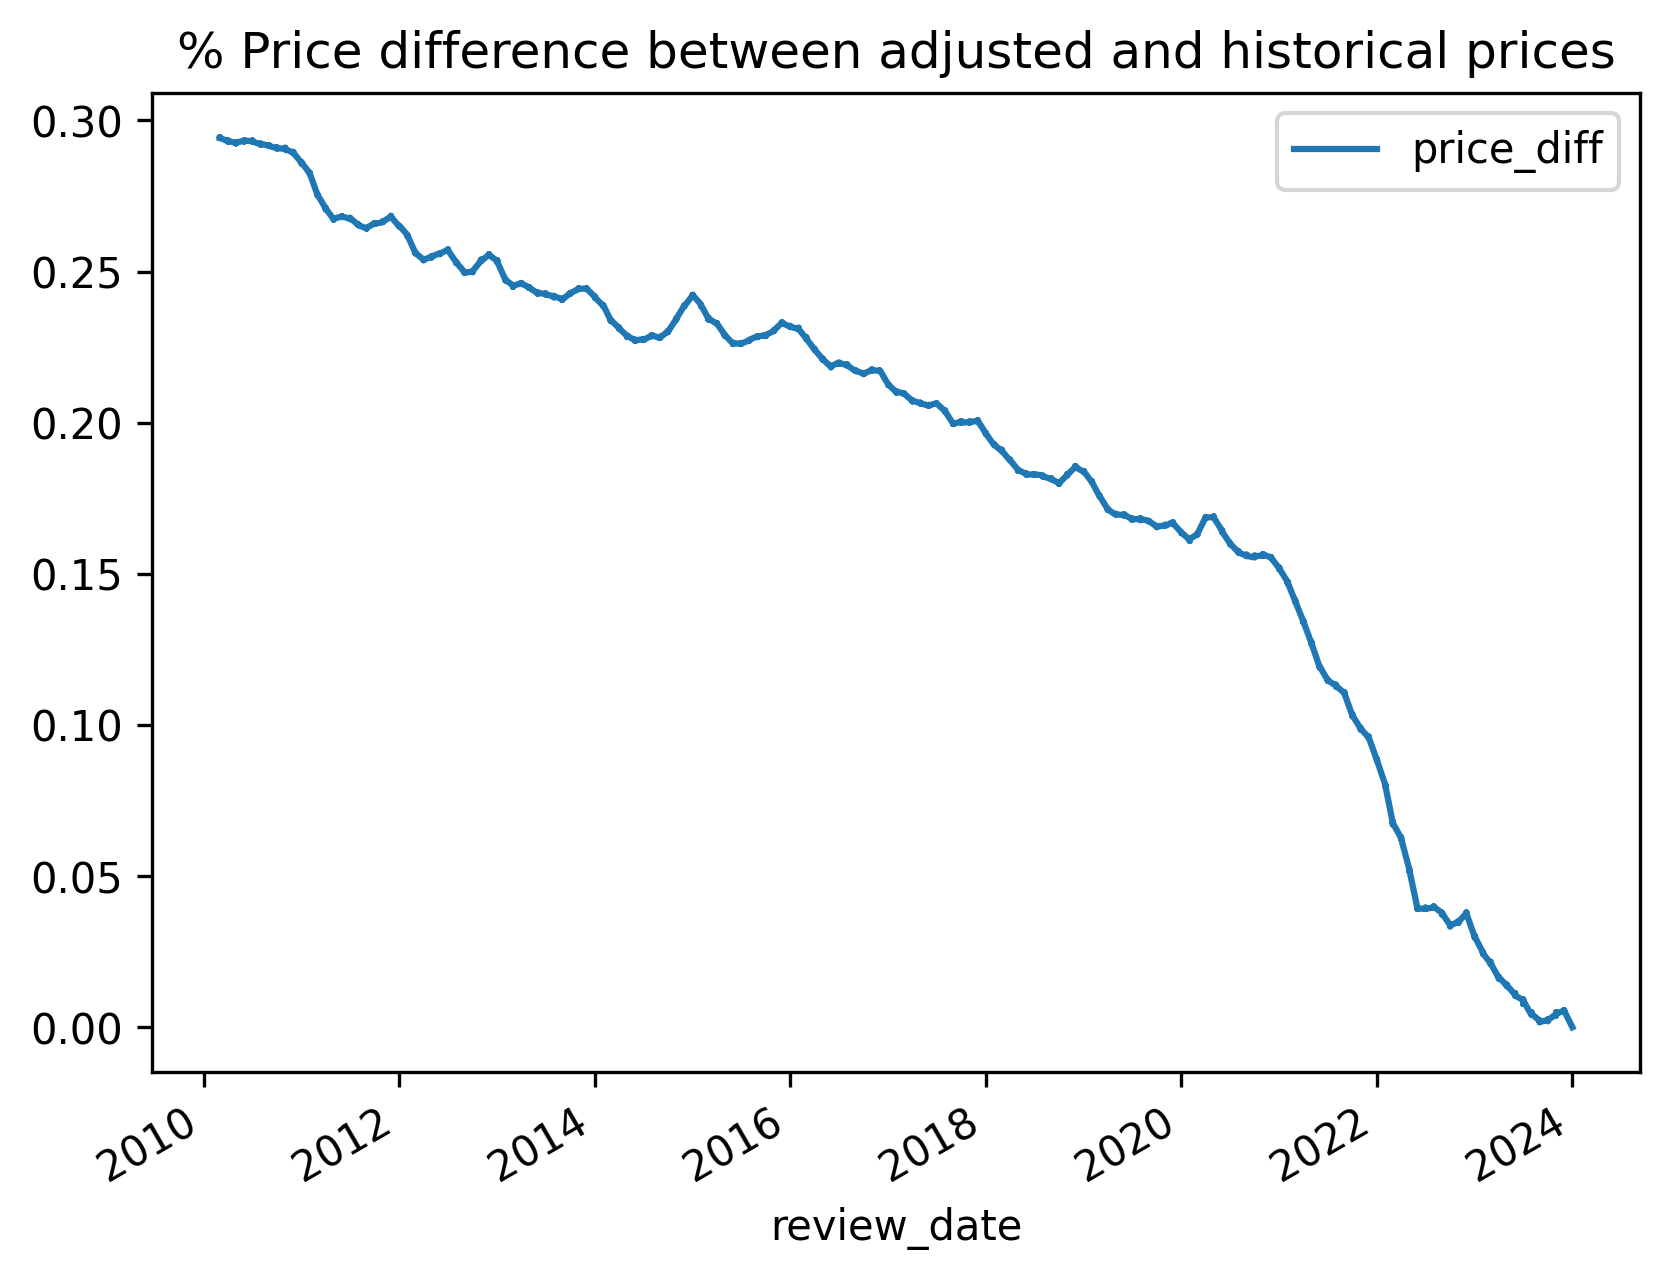

In [11]:

def load_transform_cpi(file_path: Path) -> pd.DataFrame:
    """Loads and transforms the CPI data."""
    MONTH_MAP = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    try:
        cpi = pd.read_csv(file_path, usecols=['Year',
                                              'Jan', 'Feb', 'Mar',
                                              'Apr', 'May', 'Jun',
                                              'Jul', 'Aug', 'Sep',
                                              'Oct', 'Nov', 'Dec'
                                              ]
                          )
    except FileNotFoundError:
        raise FileNotFoundError("CPI file is not found in the specified directory.")

    return (cpi
            .melt(id_vars='Year', var_name='Month', value_name='cpi')
            .assign(Month=lambda x: x['Month'].map(MONTH_MAP),
                    date=lambda x: pd.to_datetime(x[['Year', 'Month']].assign(day=1)))
            .dropna()
            .drop(columns=['Year', 'Month'])
            .rename(columns={'cpi': 'consumer_price_index'})
            .sort_values('date')
            .reset_index(drop=True)
           )
    
def create_cpi_adjusted_price(df: pd.DataFrame, file_path: Path, date: str='2024-01-01') -> pd.DataFrame:
    """
    Adjusts historical price data to 2024 prices using CPI data.
    """
    cpi = load_transform_cpi(file_path)
    cpi_baseline = cpi.loc[cpi['date'] == date, 'consumer_price_index'].values[0]
    
    return (df
            .merge(cpi, left_on="review_date", right_on="date")
            .drop(columns='date')
            .assign(price_usd_adj=lambda df_: np.round(
                df_['price_value_usd_hist'] * cpi_baseline / df_['consumer_price_index'], 2)
                    )
            )
    
data_dir = Path('../../data')
cpi_path = data_dir / 'external' / 'consumer_price_index.csv'

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
      )

df.sample(3)    

(
    df
    .assign(price_diff=lambda df_: (df_['price_usd_adj'] - df_['price_value_usd_hist'])/df_['price_usd_adj'])
).plot(x='review_date', y='price_diff', title='% Price difference between adjusted and historical prices')


### Converting quantities to lbs

In [12]:
def convert_to_lbs(df: pd.DataFrame) -> pd.DataFrame:
    to_lbs_conversion = {"ounces": 1/16, "pounds":1, "kilogram": 2.20462, "grams": 0.00220462}
    df['quantity_in_lbs'] = np.round(df['quantity_value'] * df['quantity_unit'].map(to_lbs_conversion), 2)
    return df

df =(df_raw
     .pipe(tweak_df)
     .pipe(price_quantity_split)
     .pipe(clean_currency)
     .pipe(convert_to_usd)
     .pipe(create_cpi_adjusted_price, file_path=cpi_path)
     .pipe(convert_to_lbs)
)

display(df.loc[:, ['quantity_value', 'quantity_unit', 'quantity_in_lbs']]
        .groupby("quantity_unit")
        .sample(3, replace=True)
)

,quantity_value,quantity_unit,quantity_in_lbs
3719,24.0,K-Cups,NaN
4006,24.0,K-Cups,NaN
3389,16.0,K-Cups,NaN
2759,16.0,K-cups,NaN
3064,24.0,K-cups,NaN
2765,16.0,K-cups,NaN
3428,24.0,RealCup capsules,NaN
3428,24.0,RealCup capsules,NaN
3417,48.0,RealCup capsules,NaN
3063,18.0,capsules,NaN


In [13]:
# Create a new column for price per pound
def price_per_lbs(df: pd.DataFrame) -> pd.DataFrame:
    df['price_per_lbs_adj'] = np.round(df['price_usd_adj'] / df['quantity_in_lbs'], 2)
    return df

df = (df_raw
      .pipe(tweak_df)
      .pipe(price_quantity_split)
      .pipe(clean_currency)
      .pipe(convert_to_usd)
      .pipe(create_cpi_adjusted_price, file_path=cpi_path)
      .pipe(convert_to_lbs)
      .pipe(price_per_lbs)
)

display(df.describe())

,rating,review_date,aroma,body,flavor,aftertaste,acidity,agtron_external,agtron_ground,quantity_value,price_value,price_value_usd_hist,consumer_price_index,price_usd_adj,quantity_in_lbs,price_per_lbs_adj
count,4274.000000,4274,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4274.000000,4232.000000,4232.000000
mean,92.675948,2018-01-30 07:07:53.373888768,8.751053,8.497426,8.912728,8.098971,8.408751,55.525737,74.073467,34.776556,313.115082,21.846341,257.277009,26.220620,0.673020,50.704308
min,75.000000,2010-03-01 00:00:00,5.000000,6.000000,3.000000,4.000000,5.000000,0.000000,29.000000,1.000000,3.300000,3.300000,217.631000,3.880000,0.040000,5.360000
25%,92.000000,2014-07-01 00:00:00,8.000000,8.000000,9.000000,8.000000,8.000000,53.000000,70.000000,12.000000,15.990000,14.950000,236.151000,18.410000,0.500000,25.600000
50%,93.000000,2018-10-01 00:00:00,9.000000,9.000000,9.000000,8.000000,8.000000,57.000000,76.000000,12.000000,19.450000,18.000000,252.038000,21.770000,0.750000,30.425000
75%,94.000000,2021-10-01 00:00:00,9.000000,9.000000,9.000000,8.000000,9.000000,60.000000,79.000000,12.000000,33.000000,22.942500,276.589000,26.270000,0.750000,41.345000
max,98.000000,2024-01-01 00:00:00,10.000000,10.000000,10.000000,10.000000,10.000000,86.000000,99.000000,554.000000,120000.000000,387.480000,308.417000,388.420000,6.000000,5180.000000
std,1.955998,NaN,0.523074,0.543556,0.473112,0.568939,0.607873,8.402629,8.839507,68.064454,3850.989265,16.673900,26.981851,19.456407,0.227317,123.361985


In [14]:
# list of US states
us_states_and_territories= [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming',
    'District of Columbia', 'Puerto Rico'
]

# Create a column for county. Set it eual to the value in territorial_entity_1 if it contains 'County'

def create_us_state(row):
    if row['territorial_entity_2'] in us_states_and_territories:
        return row['territorial_entity_2']
    elif row['territorial_entity_1'] in us_states_and_territories:
        return row['territorial_entity_1']
    elif row['og_roaster_location'].split(",")[-1].strip() in us_states_and_territories:
        return row['og_roaster_location'].split(",")[-1].strip()
    else:
        return np.nan


def create_county_and_state_columns(df: pd.DataFrame) -> pd.DataFrame:
    df['roaster_county'] = np.where(df['territorial_entity_1'].str.contains('County', na=False),
                                    df['territorial_entity_1'],
                                    np.nan)
    df['roaster_us_state'] = df.apply(create_us_state, axis=1)
    return df


df = (df_raw
      .pipe(tweak_df)
        .pipe(price_quantity_split)
        .pipe(clean_currency)
        .pipe(convert_to_usd)
        .pipe(create_cpi_adjusted_price, file_path=cpi_path)
        .pipe(convert_to_lbs)
        .pipe(price_per_lbs)
        .pipe(create_county_and_state_columns)
        
)


display(df.loc[df['roaster_country'] == 'USA', ['roaster_country', 'roaster_us_state', 'roaster_county']].info())

<class 'pandas.core.frame.DataFrame'>
Index: 3260 entries, 0 to 4273
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   roaster_country   3260 non-null   object
 1   roaster_us_state  3260 non-null   object
 2   roaster_county    2931 non-null   object
dtypes: object(3)
memory usage: 101.9+ KB


None

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4274 entries, 0 to 4273
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4274 non-null   int64         
 1   roaster                           4274 non-null   object        
 2   title                             4274 non-null   object        
 3   blind_assessment                  4274 non-null   object        
 4   bottom_line                       2766 non-null   object        
 5   roaster_location                  4274 non-null   object        
 6   coordinate location               4274 non-null   object        
 7   og_roaster_location               4274 non-null   object        
 8   roaster_location_identifier       4274 non-null   object        
 9   territorial_entity_1              4273 non-null   object        
 10  territorial_entity_1_identifiers  4273 non-null 

In [16]:
# Checking origin country column
df.coffee_origin_country.unique()

array(['Colombia', 'Democratic Republic of the Congo', 'Honduras',
       'Ethiopia', 'Kenya', 'Guatemala', 'Costa Rica', 'Panama', 'Peru',
       'Mexico', 'Burundi', 'Papua New Guinea', 'El Salvador',
       'United States of America', 'Nicaragua', 'India', 'Taiwan',
       'Indonesia', 'Ecuador', 'Brazil', 'Uganda', 'Thailand', 'Rwanda',
       "People's Republic of China", 'Tanzania', 'Philippines', 'Yemen',
       'Bolivia', 'Vietnam', 'Haiti', 'Zambia', 'Malaysia',
       'Dominican Republic', 'Jamaica', 'South Africa', 'Nepal',
       'Madagascar', 'Saint Helena', 'Myanmar', 'Zimbabwe', 'Malawi'],
      dtype=object)

## Column Checks

In [17]:
df = (df_raw
        .pipe(tweak_df)
        .pipe(price_quantity_split)
        .pipe(clean_currency)
        .pipe(convert_to_usd)
        .pipe(create_cpi_adjusted_price, file_path=cpi_path)
        .pipe(convert_to_lbs)
        .pipe(price_per_lbs)
        .pipe(create_county_and_state_columns)
    )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4274 entries, 0 to 4273
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            4274 non-null   int64         
 1   roaster                           4274 non-null   object        
 2   title                             4274 non-null   object        
 3   blind_assessment                  4274 non-null   object        
 4   bottom_line                       2766 non-null   object        
 5   roaster_location                  4274 non-null   object        
 6   coordinate location               4274 non-null   object        
 7   og_roaster_location               4274 non-null   object        
 8   roaster_location_identifier       4274 non-null   object        
 9   territorial_entity_1              4273 non-null   object        
 10  territorial_entity_1_identifiers  4273 non-null 

In [18]:
df_numeric = df.select_dtypes(include=['number']).drop(columns=['price_value'], axis=1)
len(df_numeric.columns)

14

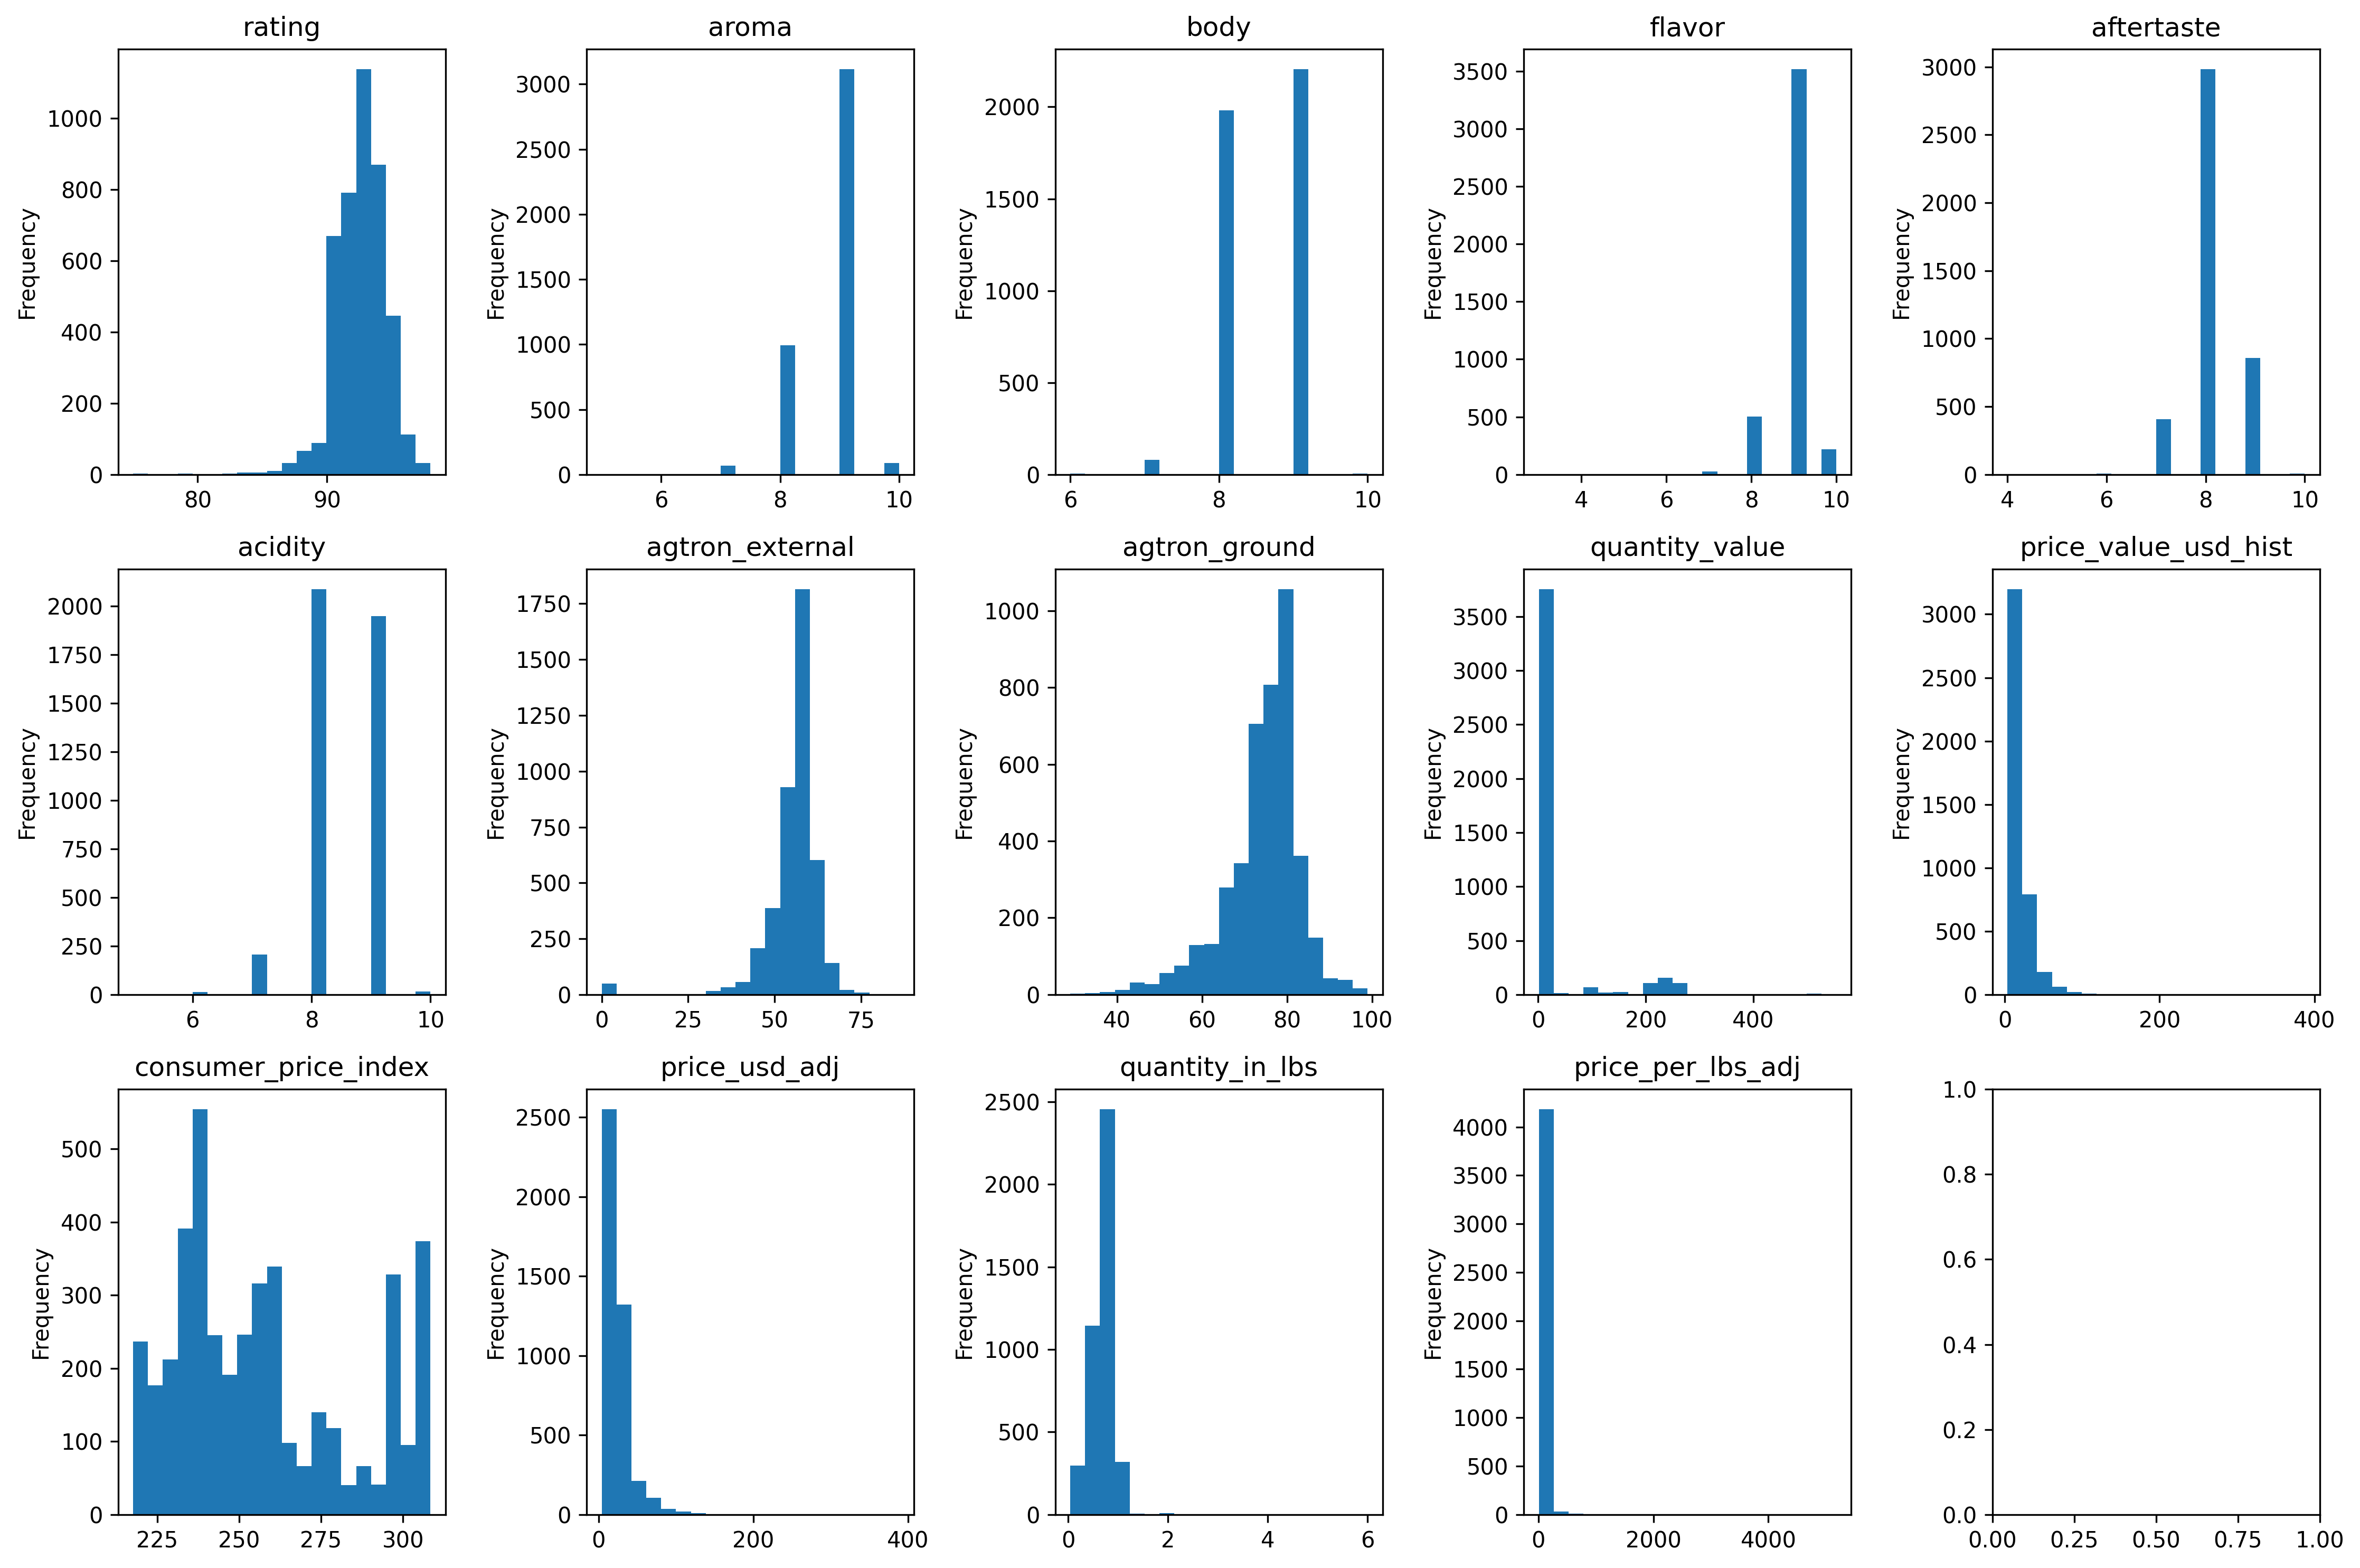

In [19]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))

for i, col in enumerate(df_numeric.columns):
    df[col].plot(kind='hist', ax=ax[i//5, i%5], title=col, bins=20)
    
plt.tight_layout()
plt.show()

In [21]:
df['price_per_lbs_adj'].describe()


count    4232.000000
mean       50.704308
std       123.361985
min         5.360000
25%        25.600000
50%        30.425000
75%        41.345000
max      5180.000000
Name: price_per_lbs_adj, dtype: float64

In [35]:
df[df['price_per_lbs_adj'] > 500].shape

(19, 40)